In [3]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import intake

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces = cat["ECCOv4r3"].to_dask()

In [8]:
#Apply Ryan's code to the dataset
ds_ll=faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('dxC', 'dyC'), ('dxG', 'dyG')])

#Exclude 1992 and put the Atlantic in the middle 
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False)
      .loc[dict(time=slice('1993-01-15','2015-12-14'))]
     .loc[dict(time_snp=slice('1993-02-01','2015-12-01'))])#

#Make a corresponding dataset of the coordinates of ds, with the same conditions as above(?)
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False)
          .loc[dict(time=slice('1993-01-15','2015-12-14'))]
         .loc[dict(time_snp=slice('1993-02-01','2015-12-01'))])#

In [9]:
def tryMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask

In [12]:
mask = tryMask(coords.hFacS.isel(k=0).load())

In [9]:
v = ((ds.VVELMASS[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k']) #integral of velocity 
v.load()

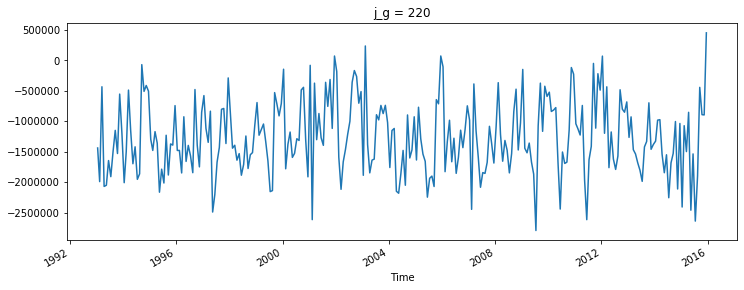

In [10]:
v.plot(figsize=(12,4))

In [16]:
t = (ds.THETA[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :] #integral of temperature

<xarray.DataArray 'THETA' (time: 276, k: 50, j: 270, i: 360)>
dask.array<shape=(276, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
Attributes:
    long_name:      Potential Temperature
    standard_name:  THETA
    units:          degC

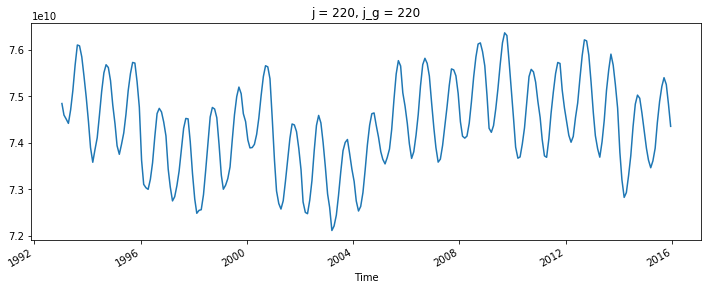

In [48]:
t_net = t.sum(['i','k']).load()
t_net.plot(figsize=(12,4))

In [ ]:
area =( coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k']).load()
area

In [68]:
net_tf_adv = v * (t_net / area)
net_tf_adv

<xarray.DataArray (time: 276)>
array([-3600083.8, -4964350. , -1081664.2, ..., -2244623.5, -2242019.8,
        1120290.4], dtype=float32)
Coordinates:
    j_g      int64 220
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    j        int64 220

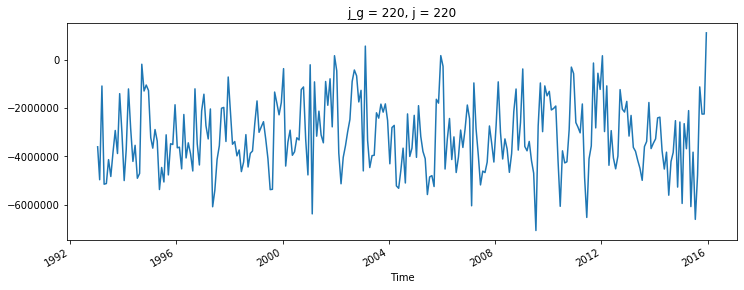

In [70]:
net_tf_adv.plot(figsize=(12,4))

In [10]:
a1=(ds['ADVy_TH'][:,:,220,110:250]).sum(['i','k']) 

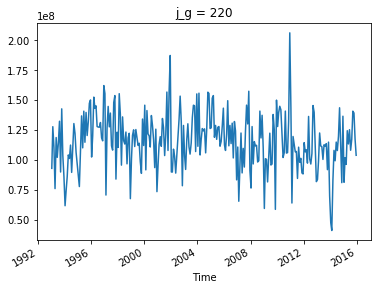

In [24]:
a2 = (ds.ADVy_TH * mask)[:, :, 220].sum(['i', 'k'])
a2.plot()

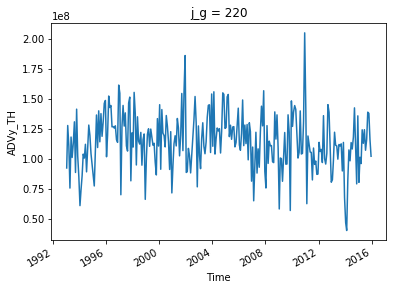

In [74]:
a1.plot()